# Análisis de ventas de libros CENGAGE

- Análisis de Ciencias de Datos
- TC2004B.100
- Profesores:
  - Rubí Isela Gutiérrez López
  - Daniel Otero Fadul
- Equipo 4

| Nombre | Matrícula |
| ---- | ---- |
| Juan Pablo Echeagaray González | A00830646 |
| Emily Rebeca Méndez Cruz | A00830768 |
| Eugenio Santisteban Zolezzi | A01720932 |
| Taurino López González | A01284076 |

Fecha: 18 de marzo del 2022


## Meta de investigación

- Predecir el comportamiento de las ventas en un mundo post-pandémico

In [1]:
# Dependencias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Following line is just there because VS Code has not fixed output rendering
from IPython.core.display import HTML
HTML(r"""
<style>
    .output-plaintext, .output-stream, .output {
        font-family: Cascadia Code; # Any monospaced font should work
        line-height: 1.3 !important;
        font-size: 14px !important;
    }
</style>
""")


## Lectura de datos

In [4]:
df = pd.read_csv('datos-reto.csv')
# La primera columna es un índice, no se necesita mantener
df.drop(df.columns[[0]], axis=1, inplace=True)


## Preprocesamiento de datos

In [5]:
df.head()


,Country,Consultant,Opportunity ID,Account,ISBN 13,Author,Title,Probability,% de Avance,Term,...,Adjusted Revenue,Technology,Course Name,Edition,Course ID,# of Courses,Customer,Client,Unlimited Flag,Implementation Id
0,Mexico,14,5255970,COLEGIO DE BACHILLERES DE CHIHUAHUA,9.786075e+12,Martinez,Literatura II,No_Aceptada,0,Aug-21,...,0,NaN,LITERATURA COBACH,1.0,1847125,NaN,Potential Customer,3705,NaN,NaN
1,Mexico,10,5172372,U-ERRE UNIVERSIDAD REGIOMONTANA,9.781338e+12,Serway/Vuille,INTL IAC WA FUNDAMENTOS DE FIS ICA,Closed Sale,1,Jan-21,...,0,WebAssign,FISICA 1 PREPA U-ERRE,11.0,1905363,NaN,Potential Customer,3681,NaN,NaN
2,Mexico,6,4496314,ITESM CAMPUS MONTERREY,9.786075e+12,CENGAGE,BIBLIOTECA DIGITAL MAGELLAN,No_Aceptada,0,Sep-20,...,0,NaN,BIBLIOTECA DIGITAL,1.0,1873177,NaN,Potential Customer,5929,NaN,NaN
3,Mexico,0,5745690,UNITEC CAMPUS CUITLAHUAC,9.786076e+12,GALINDO,MODELOS DE ORGANIZACIÓN,Evaluation Visit,0.75,May-22,...,0,NaN,Estructuras organizacionales y gestión del con...,1.0,1934416,NaN,Potential Customer,2538,NaN,NaN
4,Mexico,0,5745686,UNITEC CAMPUS CUITLAHUAC,9.786076e+12,GALINDO,MODELOS DE ORGANIZACIÓN,Evaluation Visit,0.75,Jan-22,...,0,NaN,Estructuras organizacionales y gestión del con...,1.0,1934416,NaN,Potential Customer,2538,NaN,NaN


In [6]:
df.columns


Index(['Country', 'Consultant', 'Opportunity ID', 'Account', 'ISBN 13',
       'Author', 'Title', 'Probability', '% de Avance ', 'Term',
       'New Course Takeaway Units', 'Seats', 'Units', 'Revenue',
       'Adjusted Revenue', 'Technology', 'Course Name', 'Edition', 'Course ID',
       '# of Courses', 'Customer', 'Client', 'Unlimited Flag',
       'Implementation Id'],
      dtype='object')

In [7]:
# Remover espacios blancos de las columnas
df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.columns = df.columns.str.strip()


In [8]:
df.dtypes


Country                       object
Consultant                     int64
Opportunity ID                 int64
Account                       object
ISBN 13                      float64
Author                        object
Title                         object
Probability                   object
% de Avance                   object
Term                          object
New Course Takeaway Units    float64
Seats                          int64
Units                          int64
Revenue                      float64
Adjusted Revenue               int64
Technology                    object
Course Name                   object
Edition                      float64
Course ID                      int64
# of Courses                 float64
Customer                      object
Client                         int64
Unlimited Flag               float64
Implementation Id            float64
dtype: object

In [9]:
df['Term'].unique()

array(['Aug-21', 'Jan-21', 'Sep-20', 'May-22', 'Jan-22', 'Nov-20',
       'Aug-20', 'Aug-22', 'Mar-22', 'Sep-22', 'Dec-20', 'Feb-21',
       'Feb-22', 'Dec-21', 'Mar-21', 'Sep-21', 'Nov-22', 'Dec-22',
       'Nov-21', 'Jul-20', 'Apr-21', 'Jul-22', 'May-21', 'Jul-21',
       'Jun-22', 'Oct-20', 'Apr-22', 'Jun-20', 'Jun-21', 'Oct-21',
       'Oct-22'], dtype=object)

In [10]:
df.Technology.value_counts().sum() / df.shape[0]


0.12488938942965168

Solamente el 12% de los datos cuentan con una tecnología asociada. Deberíamos de mantener esta columna? Remplazarlos con algo que represente libros tradicionales

In [12]:
df['% de Avance'].value_counts()

Base Confirmada        5976
1                      5426
0.5                    4548
0                      3265
0.25                   2097
Base por Confirmar     1958
0.75                   1194
0.1                      35
Name: % de Avance, dtype: int64

### Procesamiento de la variable `Technology`

In [13]:
df['Technology'].fillna('Copia física', inplace=True)


La columna `Technology` contenía originalmente una gran cantidad de campos vacíos; después de una reunión con el socio formador supimos que estos campos vacíos hacen alusión a libros tradicionales.

### Remover columnas con valores NaN

Hay que investigar primero de qué están compuestas estas columnas. Si encontramos algunas con una proporción de valores nulos mayor a cierta tolerancia, no deberíamos de usarlas para la creación de un modelo predictivo

In [14]:
# Completamente arbitrario (yo pensaría que >50% sería mejor)
tresh = 0.7
nan_props = []
for col in df.columns:
    nan_props.append(df[col].isnull().sum() / len(df))
    

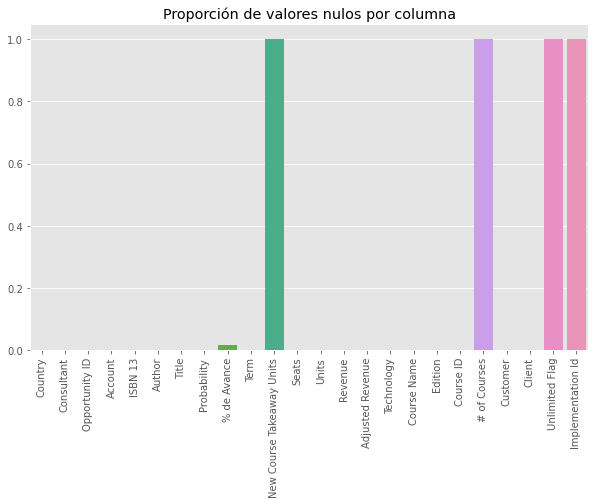

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df.columns, y=nan_props)
ax.set_title('Proporción de valores nulos por columna')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


4 de las 24 columnas de la base de datos tienen al menos un 80% de sus entradas con valores nulos, no podemos usarlas para generar un modelo predictivo.

In [16]:
# Remover todas las columnas con un porcentaje de nulos mayor al treshold
old_cols = df.columns
df.dropna(axis=1, thresh=tresh * df.shape[0], inplace=True)
new_cols = df.columns


In [17]:
old_cols.difference(new_cols)


Index(['# of Courses', 'Implementation Id', 'New Course Takeaway Units',
       'Unlimited Flag'],
      dtype='object')

Al final de este paso de limpieza hemos removido las anteriores columnas, ya que estaban compuestas de al menos un **70%** de valores NaN

### Conversión de `term` a formato `datetime`

Esta conversión facilitará la agregación y visualización de estos datos cuando entremos a la fase del análisis exploratorio de datos.

In [18]:
# Convertir a formato datetime la columna 'term'
df['Term'] = pd.to_datetime(df['Term'], format='%b-%y')


### Manipulación de variables con texto

In [19]:
df['Title'] = df['Title'].str.lower().str.strip()
df['Author'] = df['Author'].str.lower().str.strip()
df['Account'] = df['Account'].str.lower().str.strip()
df['Course Name'] = df['Course Name'].str.lower().str.strip()


### Procesamiento del `Revenue`

Dada nuestra meta de investigación, debemos de asegurarnos que la columna del `Revenue` tenga valores correctos, el determinar si la información es correcta requiere de un amplio conocimiento del negocio, pero hay algunas cosas que podemos hacer como equipo en base a las reuniones sostenidas con el socio formador.

Una primera aproximación sería corroborar que el revenue registrado coincida con las posibles categorías de la columna `Probability`. En esta columna está codificada una _pseudo-probabilidad_ de que la operación sea exitosa; como un equipo externo no podemos verificar que todas las entradas sean correctas, pero lo que sí podemos hacer es asegurarnos de que las columnas con el campo `No_Aceptada` tengan un revenue asociado de 0, el socio formador dejó en claro que cuando se da el caso de que la probabilidad tenga ese campo, esa oportunidad de negocio fue perdida.

In [20]:
df['Revenue'].describe()


count    2.486200e+04
mean     8.626979e+03
std      2.623013e+04
min      0.000000e+00
25%      1.634160e+03
50%      3.300000e+03
75%      7.365600e+03
max      1.308277e+06
Name: Revenue, dtype: float64

La distribución de esta variable sigue un comportamiento bastante atípico, vemos que al menos el 75% de los datos se encuentran en un rango de valores desde 0 a \$7,365, pero luego de eso vemos que hay una entrada con un valor de $1,308,000 aproximadamente, 3 ordenes de magnitud no es algo que podamos pasar por alto.

In [21]:
# Investigar el caso del revenue máximo
df[df['Revenue'] == df['Revenue'].max()]

,Country,Consultant,Opportunity ID,Account,ISBN 13,Author,Title,Probability,% de Avance,Term,Seats,Units,Revenue,Adjusted Revenue,Technology,Course Name,Edition,Course ID,Customer,Client
0,Mexico,14,5255970,colegio de bachilleres de chihuahua,9.786075e+12,martinez,literatura ii,No_Aceptada,0,2021-08-01,10000,8929,1308277.08,0,Copia física,literatura cobach,1.0,1847125,Potential Customer,3705


Vemos que para el caso de la operación con el valor máximo de revenue la categoría de `Probability` tiene un valor de `No_Aceptada`, esto nos indica que existe la posibilidad de que varias entradas de la base de datos tengan un `Revenue` asociado que no haya sido actualizado. En este caso haremos nulo el revenue para todas las entradas que tengan como `No_Aceptada` la categoría de `Probability`.

In [22]:
df.loc[df['Probability'] == 'No_Aceptada', 'Revenue'] = 0


### Procesamiento del `% de Avance`

El `% de Avance` es una variable que depende directamente de la columna `Probability`, hay que asegurarse que los valores de la primera estén acorde a lo que implica determinada probabilidad.

In [23]:
# Hacer que cuando la base sea perdida o no aceptada, el % de Avance sea 0
df.loc[df['Probability'] == 'No_Aceptada', '% de Avance'] = 0
df.loc[df['Probability'] == 'Base_Perdida', '% de Avance'] = 0

# Codificar la base confirmada como con una probabilidad de 1
df['% de Avance'] = df['% de Avance'].str.strip()
df.loc[df['% de Avance'] == 'Base Confirmada', '% de Avance'] = '1'
# Modificaremos la Base por Confirmar a un 30%
df.loc[df['% de Avance'] == 'Base por Confirmar', '% de Avance'] = '0.3'


In [24]:
df['% de Avance'] = pd.to_numeric(df['% de Avance'], downcast='float', errors='coerce')


### Investigando el `Adjusted Revenue`

In [25]:
df['Adjusted Revenue'].describe()


count    24862.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Adjusted Revenue, dtype: float64

Como esta columna está llena de valores nulos, no podemos usarla para generar un modelo predictivo o de clasificación. Tendremos que dejarla de lado.

In [26]:
df.drop(['Adjusted Revenue'], axis=1, inplace=True)

### Tratamiento de la variable `Probability`

In [27]:
df.Probability.value_counts()

Closed Sale            5366
Muestra                4548
Base_Vendida           3877
No_Aceptada            2165
Base_Confirmada        2099
Interview              2097
Base_Por_Confirmar     1958
Evaluation Visit       1194
Identified Prospect    1100
Base_Perdida            363
Vendida                  60
Custom Adoption          29
At Risk                   6
Name: Probability, dtype: int64

Tal vez sea buena idea usar la función de pandas para hacer que esta variable categórica se convierta a ordinal

- Base confirmada -> Socios conocidos de antes, es como algo recurrente
- 100% -> cuando hay un proceso de venta, es para clientes nuevos

Posible ordenamiento, estoy tratando de acomodarlas por niveles, hay varias que tienen el mismo _peso_:
1. Base confirmada, Closed Sale, Base_Vendida, Vendida
2. Evaluation Visit -> 75
3. Muestra, Base por Confirmar (0.3) -> 50
4. Interview -> 25
5. At risk, Custom Adoption -> 10
6. No_Aceptada, Base_Perdida, Identified Prospect -> 0

**IMPORTANTE** Proponer que el revenue que usemos sea una multiplicación de la probabilidad por el revenue que viene en la base de datos. Consultar segunda sesión con el socio formador, 1:21:00 del video lo explica

## Análisis exploratorio de datos

### Correlación

Text(0.5, 1.0, 'Correlación')

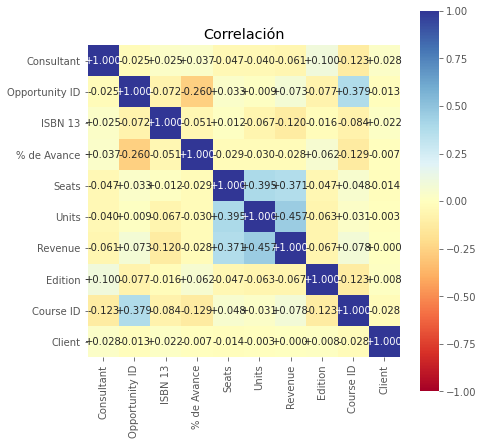

In [28]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Correlación")

Como se puede ver, las dos variables que poseen más coorelación entre ellas son la variable 'Revenue' y la variable 'Units', por lo que podemos analizar un poco sobre estos.

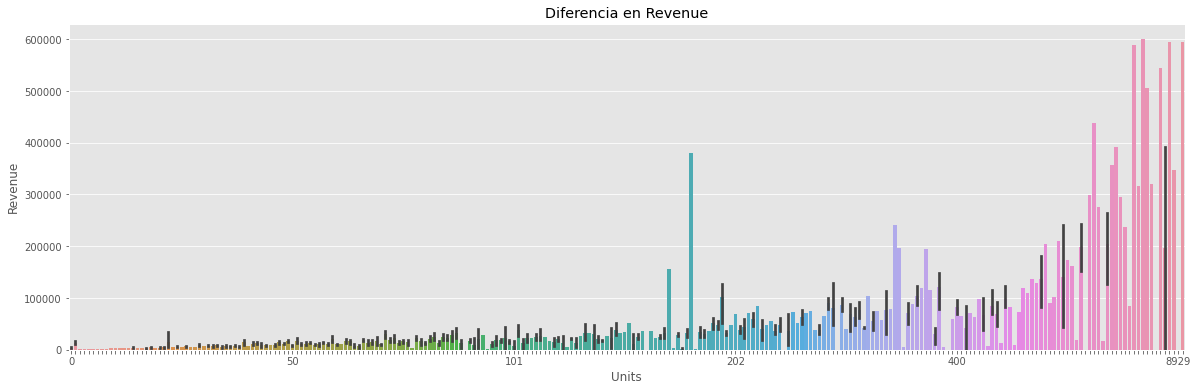

In [49]:
plt.figure(figsize=(20, 6))
plot = sns.barplot(data=df, x='Units', y='Revenue')
sns.set_palette('Set1')

plt.title('Diferencia en Revenue')
plt.xlabel('Units')
plt.ylabel('Revenue')

for index, label in enumerate(plot.get_xticklabels()):
   if index % 50 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

<AxesSubplot:xlabel='Units', ylabel='Revenue'>

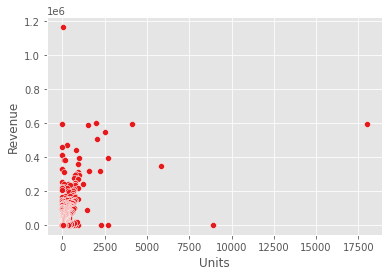

In [30]:
sns.scatterplot(x='Units', y='Revenue', data=df)

De manera generalizada, analizando estas gráficas, podemos percatarnos de que la gran mayoría de los valores que se encuentran en la base de datos se encuentran cuando las unidades son menores a 3,000, y en ingresos esos tienen un impacto razonable mostrando valores alrededor de 600,000. Sin embargo, hay algunos valores que se encuentran bastante alejados de la mayoría, con una cantidad de 17,500 unidades o con ingresos considerablemente más altos.

### Investigando a los consultores

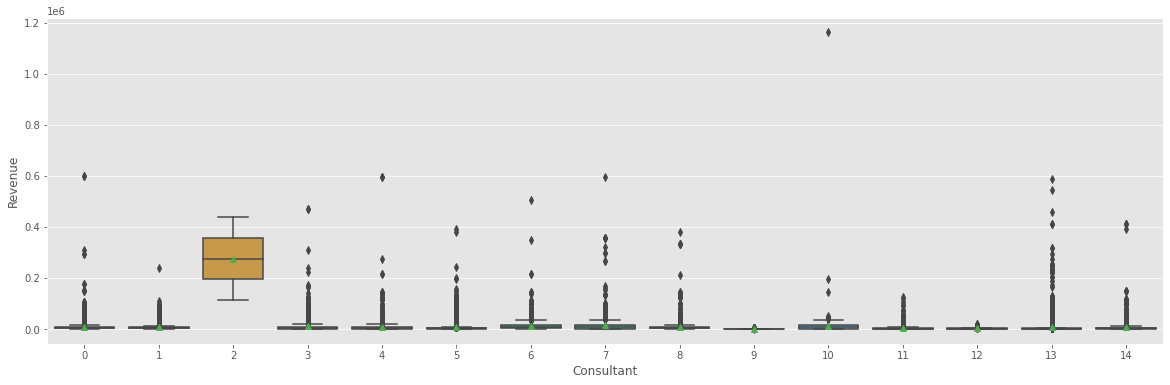

In [34]:
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x='Consultant', y='Revenue', data=df, showmeans=True)


Dada la distribución tan extrema del revenue por cada consultor, conviene discretizar estos valores en diferentes categorías que encapsulen el nivel del revenue, un ejemplo algo burdo sería `bajo`, `medio`, `alto`.

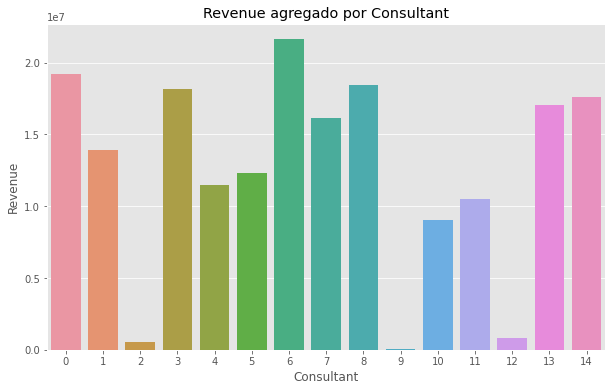

In [35]:
plt.figure(figsize=(10, 6))
agg_revenue = df.groupby('Consultant').sum()['Revenue']
ax = sns.barplot(x=agg_revenue.index, y=agg_revenue)
ax.set_title('Revenue agregado por Consultant');


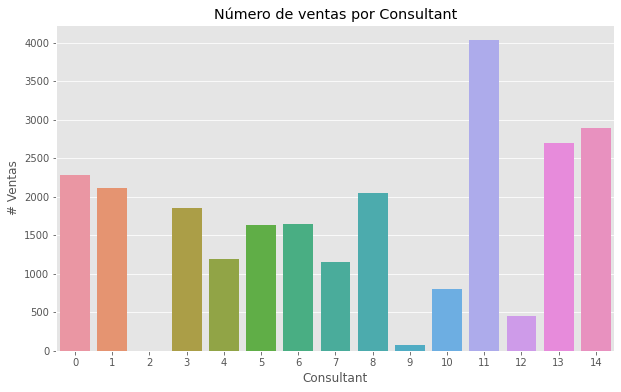

In [36]:
# Número de operaciones por consultant
plt.figure(figsize=(10, 6))
agg_ops = df['Consultant'].value_counts().sort_index()
ax = sns.barplot(x=agg_ops.index, y=agg_ops)
ax.set_title('Número de ventas por Consultant');
ax.set_ylabel('# Ventas');
ax.set_xlabel('Consultant');


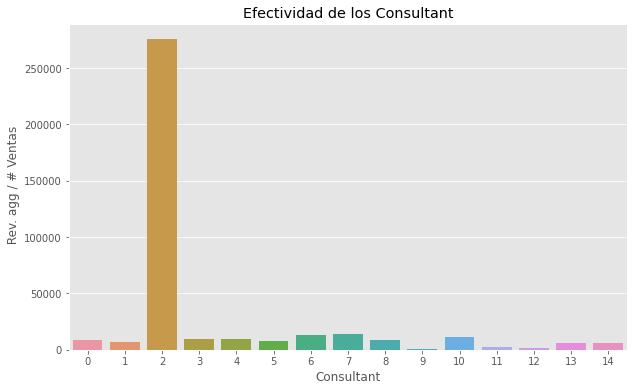

In [37]:
# Efectividad de los consultant? Revenue agregado / # operaciones
plt.figure(figsize=(10, 6))
effectiveness = agg_revenue / agg_ops
ax = sns.barplot(x=agg_ops.index, y=effectiveness);
ax.set_title('Efectividad de los Consultant')
ax.set_ylabel(' Rev. agg / # Ventas')
ax.set_xlabel('Consultant');


El caso del consultor 2 tal vez debería de ser analizado con más cuidado, ha tenido ventas con un revenue no tan grande, pero solo ha tenido 2 ventas durante todo el periodo de registro de la base de datos

In [38]:
# Hacer que esto analice el consultant con mayor efectividad?
consultant = 2
df.Consultant.value_counts().sort_index()[consultant]


2

### Comportamiento del `Revenue` a través del tiempo

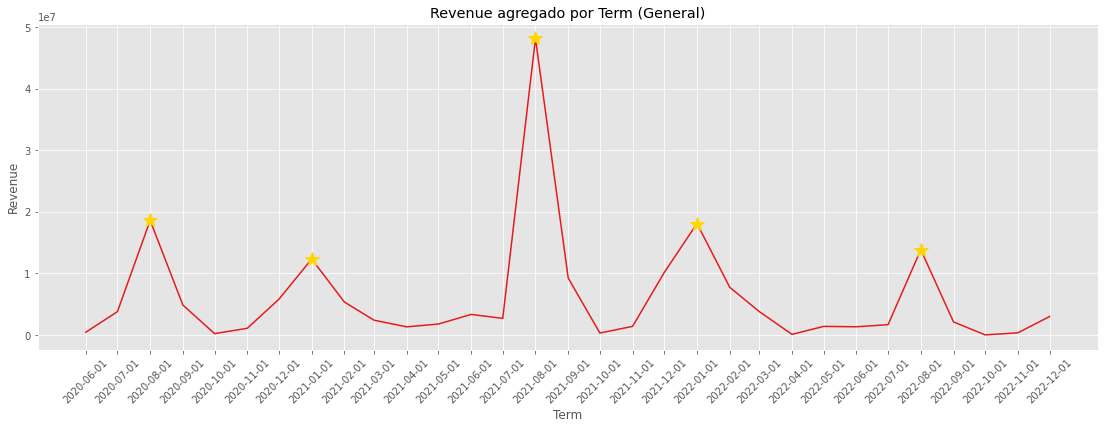

In [39]:
import matplotlib.cm as cm
from scipy.signal import find_peaks

plt.figure(figsize=(19, 6))
agg_revenue_term = df.groupby('Term').sum()['Revenue']
ax = sns.lineplot(x=agg_revenue_term.index, y=agg_revenue_term)
ax.set_title('Revenue agregado por Term (General)');
plt.xticks(agg_revenue_term.index, rotation=45);

# Encontrar los máximos locales
peaks, _ = find_peaks(agg_revenue_term, distance=5);
# Plot the peaks
plt.plot(agg_revenue_term.index[peaks], agg_revenue_term[peaks], "*", markersize=15, color='gold');


Vemos claramente que los picos del gráfico corresponden a los periodos de inicio de semestre. Lo primero que salta a la vista es que el patrón observado en los primeros 4 máximos no se repite con la última observación; esto no es un indicador de que las ventas de CENGAGE se hayan desplomado, sino que la base de datos de la que disponemos al momento de hacer este estudio no llega hasta la fecha más actual.

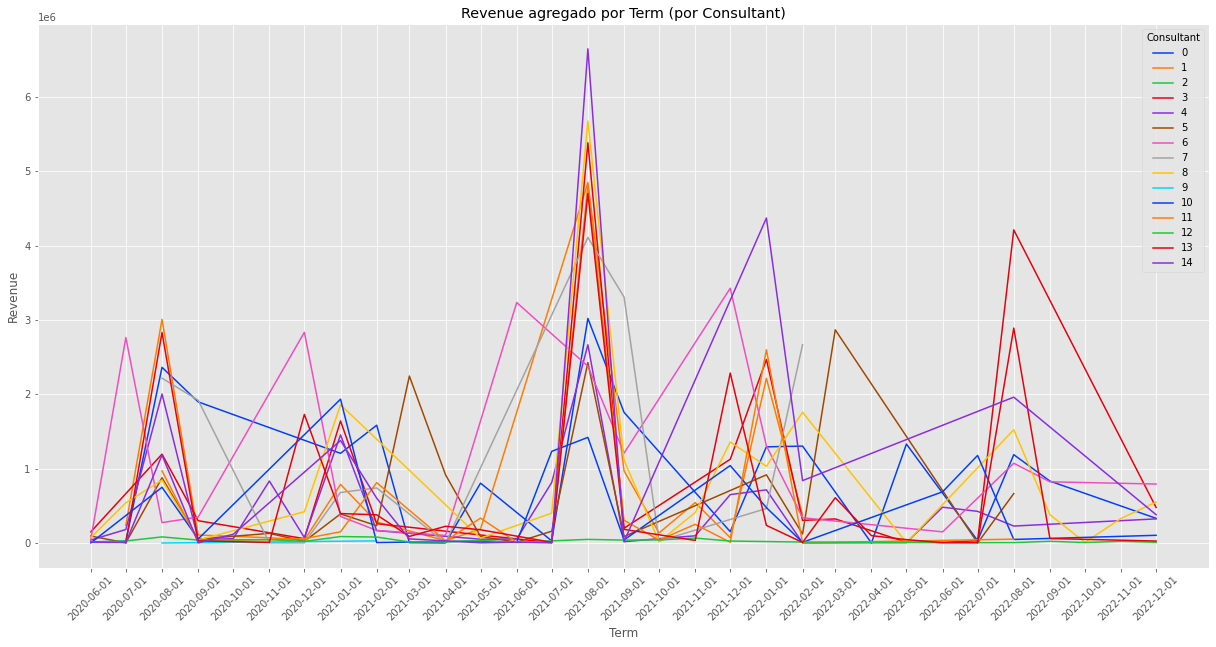

In [40]:
plt.figure(figsize=(21, 10))
# Seaborn agrega los datos en este paso?
ax = sns.lineplot(x='Term', y='Revenue', hue='Consultant', data=df,
                  legend='full', ci=None, palette='bright', estimator=np.sum)
plt.xticks(agg_revenue_term.index, rotation=45)
ax.set_title('Revenue agregado por Term (por Consultant)');


Aunque la gráfica anterior parezca algo comprimida, podemos ver claramente dónde se encuentran los picos de venta que habíamos avistado en la gráfica anterior. Aunado a esto, vemos que en el último periodo no hay muchos consultores que hayan registrado ventas, de alguna manera deberíamos de tener en cuenta este hecho para cualquier método de predicción (o clasificación) que vayamos a implementar.